## Project Report 

This is the report for the first project in the Udacity Deep Reinforcement Learning Nanodegree. The purpose of this project is to let us learn to use Deep Q Network (DQN) to train an agent. The agent needs to navigate the game environment and collect as many yellow bananas as possible while avoiding blue bananas.

I am using the code for fixed DQN from https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution as a starting point. Then I create the agent that is based on Double DQN (DDQN) with/without prioritized replay. 
I refer to https://github.com/higgsfield/RL-Adventure for the prioritized experience replay. 

To train the agnet, we can run the codes in 'Navigation_main.ipynb'. In that notebook, the plot of the total rewards of each episode in the training process is plot. The trained models are saved to respective checkpoint.pth files. 

In the report, we will see the performance of the trained model.To do so, we will load agent with pretrained parameters and let the agent play with the environment. We then will check the average score of playing 100 episode for each model. 

In [2]:
import torch
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
from unityagents import UnityEnvironment

In [3]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
# load the weights from file
def let_agent_play(version_name):
    # load a pre-trained model
    agent.qnetwork_local.load_state_dict(torch.load(version_name+'_checkpoint.pth'))
    max_t=1000
    eps_end=0.01
    play_episodes=100
    play_scores = []                        # list containing scores from each episode
    play_scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, play_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]         
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps_end)
    #             next_state, reward, done, _ = env.step(action)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
    #             agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        play_scores_window.append(score)       # save most recent score
        play_scores.append(score)              # save most recent score
    #         eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(play_scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(play_scores_window)))
    return play_scores

In [7]:
# plot the scores
def plot_dqn(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

## Baseline Fixed DQN

The fixed DQN is provided by https://github.com/udacity/deep-reinforcement-learning/tree/master/dqn/solution .
I found that the performance of this baseline fixed DQN is quite good. In most times the agent will learn to obtain an average score of 13 before within 500 episodes.  In navigation_main.ipynb, we can see that after episode 679	it achived an average Score: 15.02.

Episode 100	Average Score: 13.65


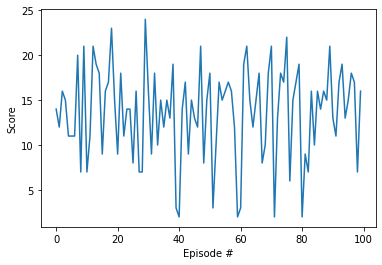

In [8]:
version='baseline'
from baseline_dqn_agent import Agent
agent = Agent(state_size=37, action_size=4, seed=0)
play_scores=let_agent_play('baseline')
plot_dqn(play_scores)

## Double DQN
In double DQN, in the learning function, we will let qnetwork_local choose action for the next state, and use qnetwork_target to evaluate the q value. 

> In fixed DQN, we will let the maximum Q value of the qnetwork_target to be the Q_targets_next:

>> Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

> In double DQN, we will first choose the next action and use Qnetwork_target to evaluate the q value:
    
>>      with torch.no_grad():
            next_action_values = self.qnetwork_local(next_states)
     self.qnetwork_local.train()
     chosen_actions=next_action_values.detach().max(1)[1].unsqueeze(1)
     Q_targets_next = self.qnetwork_target(next_states).gather(1, chosen_actions)
        
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
In navigation_main.ipynb, we can see that after episode 623	it achived an average Score: 15.08. 

Episode 100	Average Score: 16.19


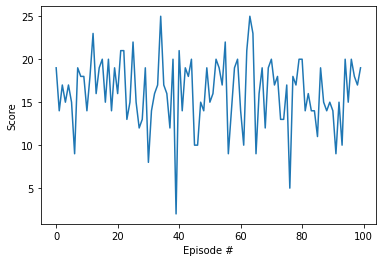

In [9]:
version='double_Q_agent_base_replay'
from baseline_dqn_agent import Agent
agent = Agent(state_size=37, action_size=4, seed=0)
play_scores=let_agent_play(version)
plot_dqn(play_scores)

## Double DQN+Prioritized Experience Replay (PER)
Previously, the mini-batch is sampled with uniform distribution. In PER, the experiences in the replay buffer are sampled with different priorities. Suppose that each experience *i* has a priority of $p_i$.

The probability of each experience is calculated as:
$P(i)=(|p_i|+\epsilon)/\sum_{i}(|p_i|+\epsilon)$.

Weights $w_i=(N\times P(i))^{-\beta}/max_j w_j$

Priority is updated: $p_i=|Q\_target(i)-Q\_expected(i)|$

The choice of parameters:
 - $\epsilon=0.1$.
 - $\alpha=0.5$
 - $\beta=0.5 \rightarrow 1$
 
But the performance of the DQN training is actually worse than fixed DQN and double DQN, because it takes more episodes to converge and the training is slowed down probabily by the importance sampling step. 
I also found similar issue reported in https://knowledge.udacity.com/questions/148274.

In navigation_main.ipynb, we can see that after episode 1000 it achived an average Score: 13.48. 

Episode 100	Average Score: 13.92


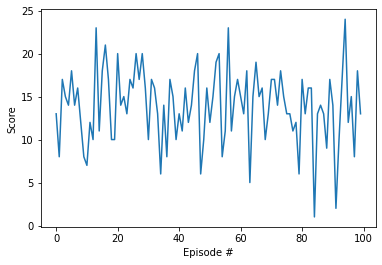

In [13]:
version='double_Q_agent_prio_replay'
from baseline_dqn_agent import Agent
agent = Agent(state_size=37, action_size=4, seed=0)
play_scores=let_agent_play(version)
plot_dqn(play_scores)

## Conclusion
While it is easy to train the fixed DQN and double DQN. From the rewards in the training process, we may think that the performance of fixed DQN is similar to double DQN. But when we let the trained agent play the game, we will find that the average score of fixed DQN is 13.65, while that of the double DQN is 16.19. We may conclude that the performance of double DQN is indeed better, and fixed DQN seems to overestimate the values of some actions action.

The performance of the PER is only slightly better than fixed DQN and worse than double DQN. I am still wondering what causes this reduction of performance?

Ideas for Future Work: 
    - Dueling DQN;
    - Train an agent from raw pixels; take more than 1 frames as state;
    - Use rainbow DQN. 

This concludes the report. 

In [14]:
env.close()